In [1]:
import pandas as pd
import numpy as np
import cbsodata
from functions import *

In [2]:
# Search for all datasets related to jeugdhulp in the CBS Open Data API
tables = cbsodata.get_table_list()
print([f"{t['Identifier']} - {t['Title']}" for t in tables if 'jeugdhulp' in t['Title'].lower() or 'jeugdzorg' in t['Title'].lower()])
questionnaires = [83454,85685,82968,85097]
# potentially interesting tables
gemeentes = ['Delft', "'s-Gravenhage", "'s-Gravenhage (gemeente)", 'Den haag', 'Leidschendam-Voorburg', 'Midden-Delfland',
 'Pijnacker-Nootdorp', 'Rijswijk', 'Rijswijk (ZH.)', 'Wassenaar', 'Westland', 'Zoetermeer']
# haaglanden gemeentes

['85099NED - Kerncijfers over jeugdzorg', '85098NED - Indicatoren jeugdzorg in natura; gemeenten', '85096NED - Jeugdhulptrajecten in natura; verwijzer', '85097NED - Jeugdhulptrajecten in natura; verwijzer, regio (gemeente)', '85101NED - Jongeren met één of meerdere vormen van jeugdzorg', '85102NED - Jongeren met één of meerdere vormen van jeugdzorg in natura; peildatum', '85100NED - Jongeren met jeugdzorg; persoonskenmerken', '85095NED - Jongeren met jeugdzorg in natura; persoonskenmerken, op peildatum', '85094NED - Trajecten jeugdzorg in natura; regio (gemeente), op peildatum', '84134NED - Kerncijfers over jeugdzorg, 2015-2020', '82972NED - Indicatoren jeugdzorg in natura; gemeenten, 2015-2020', '82970NED - Jeugdhulptrajecten in natura; verwijzer, perspectief, 2015-2020', '82971NED - Jeugdhulptrajecten in natura; verwijzer, regio (gemeente), 2015-2020', '82969NED - Jongeren met jeugdzorg in natura; persoonskenmerken, peildatum, 2015-2020', '84136NED - Jongeren met één of meerdere vorm

In [3]:
data = cbsodata.get_data(f'{questionnaires[0]}NED')
df = pd.DataFrame(data)
df = df[df.Regio.isin(gemeentes)].dropna()
kosten = df[(df['VormenVanJeugdzorg'] == 'JH 1 Totaal jeugdhulp') & (df['Perioden'] == '2023')]
kosten.drop(columns=['ID', 'VormenVanJeugdzorg', 'Perioden'], inplace=True)
kosten.rename(columns={'Regio': 'Gemeente'}, inplace=True)
remove_whitespace(kosten, rem_nr=True)



C:\Users\Tijn\AppData\Local\Temp\ipykernel_5808\2785626022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kosten.drop(columns=['ID', 'VormenVanJeugdzorg', 'Perioden'], inplace=True)
C:\Users\Tijn\AppData\Local\Temp\ipykernel_5808\2785626022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kosten.rename(columns={'Regio': 'Gemeente'}, inplace=True)


In [4]:

# Paging function to fetch data in chunks (with filter)
def fetch_filtered_data(base_url, filter_str, top=100, max_records=200):
    import requests
    all_records = []
    skip = 0
    while True:
        url = f"{base_url}?$format=json&$top={top}&$skip={skip}&$filter={filter_str}"

        response = requests.get(url)
        response.raise_for_status()
        data = response.json().get("value", [])

        if not data:
            break

        all_records.extend(data)
        skip += top

        if len(all_records) >= max_records:
            print(f"{len(all_records)} records fetched, stopping to avoid overload.")
            break
    print(f"Fetched {len(all_records)} records.")

    return pd.DataFrame(all_records)

def fetch_data(base_url, df=True):
    import requests
    reponse = requests.get(base_url).json()
    if df:
        return pd.json_normalize(reponse['value'])
    else:
        return reponse

In [5]:
import requests

baseurl = "https://dataderden.cbs.nl/ODataApi/odata/50131NED"
metadata = fetch_data(baseurl, df=False)
metadata_keys = [dic['name'] for dic in metadata[list(metadata.keys())[1]]]

baseurl= f'https://dataderden.cbs.nl/ODataApi/odata/50131NED/{metadata_keys[-2]}'
df_marges = fetch_data(baseurl)
marge_key = df_marges[df_marges['Title'] == 'Waarde']['Key'].values[0]

baseurl = f"https://dataderden.cbs.nl/ODataApi/odata/50131NED/{metadata_keys[-3]}"
df_persoonskern = fetch_data(baseurl)
filtered_df = df_persoonskern[df_persoonskern['CategoryGroupID'].isin([1,2,4])]
dict_perskeys = dict(zip(filtered_df['Key'], filtered_df['Title']))

baseurl = f"https://dataderden.cbs.nl/ODataApi/odata/50131NED/{metadata_keys[-1]}"
df_regio = fetch_data(baseurl)
df_filtered = df_regio[df_regio['Title'].isin(gemeentes)]
dict_regiokeys = dict(zip(df_filtered['Key'], df_filtered['Title']))

baseurl = f"https://dataderden.cbs.nl/ODataApi/odata/50131NED/{metadata_keys[2]}"
# create a filter string for regio
filter_str = " or ".join([f"RegioS eq '{code}'" for code in dict_regiokeys.keys()])

df_jeugdhulp = fetch_filtered_data(baseurl, filter_str=filter_str, top=1000, max_records=2000)
df_jeugdhulp = df_jeugdhulp[df_jeugdhulp['Marges'] == marge_key].drop(columns=['Marges'])
df_jeugdhulp = df_jeugdhulp[df_jeugdhulp['Persoonskenmerken'].isin(dict_perskeys.keys())]
# replace the keys with the titles
df_jeugdhulp['Persoonskenmerken'] = df_jeugdhulp['Persoonskenmerken'].replace(dict_perskeys)
df_jeugdhulp['RegioS'] = df_jeugdhulp['RegioS'].replace(dict_regiokeys)
# count the missing values in the rows
df_jeugdhulp.set_index('ID', inplace=True)
to_drop = df_jeugdhulp.transpose().isna().sum() >= 63
# keep only the rows with more than 63 missing values
df_jeugdhulp = df_jeugdhulp[~to_drop]
remove_whitespace(df_jeugdhulp, rem_nr=True)

Fetched 270 records.


In [6]:
# Retrieve Data for the second questionnaire about youth care
# Retrieved information about Age, Household, and Referrals
# The data is filtered for the municipalities of interest (Haaglanden municipalities)

data = cbsodata.get_data(f'{questionnaires[1]}NED')
df = pd.DataFrame(data)
remove_whitespace(df, rem_nr=False)
df = df[df.Wijken.isin(gemeentes)].dropna(how='all')
df = df[df['Perioden'] == '2023']
df.columns = [(' ').join(x.split('_')[:-1]) if '_' in x else x for x in df.columns.tolist()]
df.columns = [x.split('k ')[1] if 'k ' in x else x for x in df.columns.tolist()]
df = df[df['Vormen Van Jeugdzorg'] == 'Totaal jeugdhulp in natura']
df.rename(columns={'Totaal Jongeren Met Jeugdzorg In Natura': 'Jongeren', 'Totaal Trajecten In Natura': 'Trajecten', 'Vormen Van Jeugdzorg': 'Vormen'}, inplace=True)
basis = df[['Wijken', 'Jongeren', 'Trajecten']]
for col in ['Gemeentenaam', 'Soort Regio', 'Indelingswijziging Wijken', 'ID', 'Vormen', 'Perioden', 'Codering']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
leeftijd = pd.concat([basis[['Wijken', 'Jongeren']], df.iloc[:, 2:6]], axis=1)
huishouden = pd.concat([basis[['Wijken', 'Jongeren']], df.iloc[:, 6:9]], axis=1)
huishouden.columns = ['Wijken', 'Jongeren', 'Thuiswonend Eenouder',
       'Thuiswonend Paar', 'Ander Huishouden']
verwijzers = pd.concat([basis[['Wijken', 'Trajecten']], df.iloc[:, 10:18]], axis=1)


In [7]:
tevr_kost = pd.merge(df_jeugdhulp, kosten, left_on='Regio S', right_on='Gemeente', how='inner')
tevr_kost.drop(columns=['Regio S'], inplace=True)
remove_whitespace(tevr_kost)

tevr_kost.rename(columns={'Gemeente': 'Wijken'}, inplace=True)
tevr_kost['Wijken'] = df['Wijken'].unique()
summ_df = pd.merge(tevr_kost, df, on='Wijken', how='inner')

summ_df.drop(columns=['Persoonskenmerken'], inplace=True)
summ_df.set_index('Wijken', inplace=True)
summ_df.dropna(axis=1, inplace=True)

In [18]:
test_df.iloc[:,68:]

,0 Tot 4 Jaar,4 Tot 12 Jaar,12 Tot 18 Jaar,18 Tot 23 Jaar,Thuiswonend Kind In Eenouderhuishouden,Thuiswonend Kind Bij Een Paar,Ander Huishouden,Gemeentelijke Toegang,Huisarts,Jeugdarts,Gecertificeerde Instelling,Medisch Specialist,Geen Verwijzer
Wijken,,,,,,,,,,,,,
Delft,0.059480,0.473978,0.418216,0.048327,0.368030,0.559480,0.072491,0.270878,0.270878,0.017131,0.092077,0.031049,0.317987
's-Gravenhage,0.111315,0.466667,0.394495,0.027523,0.340979,0.583486,0.075535,0.149573,0.364219,0.046037,0.083528,0.033605,0.323038
Leidschendam-Voorburg,0.055928,0.494407,0.436242,0.013423,0.301339,0.640625,0.058036,0.192248,0.494574,0.038760,0.083721,0.051163,0.139535
Midden-Delfland,0.034091,0.500000,0.420455,0.045455,0.215909,0.727273,0.056818,0.280000,0.480000,0.024000,0.064000,0.032000,0.120000
Pijnacker-Nootdorp,0.044568,0.481894,0.451253,0.022284,0.206704,0.762570,0.030726,0.273707,0.471983,0.023707,0.051724,0.064655,0.114224
Rijswijk,0.093656,0.537764,0.350453,0.018127,0.367470,0.593373,0.039157,0.196040,0.453465,0.035644,0.079208,0.041584,0.194059
Wassenaar,0.039370,0.417323,0.527559,0.015748,0.257812,0.679688,0.062500,0.112360,0.556180,0.033708,0.073034,0.056180,0.168539
Westland,0.043845,0.497470,0.430017,0.028668,0.203704,0.747475,0.048822,0.354214,0.369021,0.013667,0.061503,0.043280,0.158314
Zoetermeer,0.050473,0.507886,0.426919,0.014721,0.298633,0.644585,0.056782,0.259313,0.460920,0.039445,0.088386,0.055515,0.096421


In [ ]:
test_df = summ_df.copy()
test_df = normalize(test_df, test_df.columns[69:73], axis=1)
test_df = normalize(test_df, test_df.columns[73:76], axis=1)
test_df = normalize(test_df, test_df.columns[77:], axis=1)
test_df = normalize(test_df, test_df.columns[64:68], axis=0)
test_df.iloc[:, 1:28] = test_df.iloc[:, :64] / 100

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
test_df.drop(columns=['Jongeren', 'Trajecten'], inplace=True)
X = test_df.iloc[:,1:29]

y = test_df[test_df.columns[test_df.columns.str.contains('Jaar')].tolist()[0]]
lr.fit(X, y)
lr.coef_
# sort the coefficients in descending order and match them with the column names
coef_df = pd.DataFrame(lr.coef_, X.columns, columns=['coefficients'])
coef_df = coef_df.sort_values(by='coefficients', ascending=False)
coef_df = coef_df.reset_index()
coef_df.columns = ['Feature', 'Coefficient']
coef_df

# PROBABLY NEEDS SOME ADDITIONAL NORMALIZATION BETWEEN THE CITIES FOR THE TARGET COLUMNS TO INCREASE DISCREPENCIES

,Feature,Coefficient
0,Stress Door Situatie Thuis Vaak,0.204403
1,Veel Vertrouwen In Toekomst,0.108864
2,Weinig Geen Vertrouwen In Toekomst,0.085659
3,Ongelukkig Voelen Meestal,0.067665
4,Psychische Klachten,0.046763
5,Gespijbeld 3 Meer Uren Afg 4 Weken,0.042810
6,Eenzaam Soms Tot Altijd Afg 4 Weken,0.017790
7,Suicidegedachten Heel Vaak Afg 12 Mnd,0.009946
8,Stress Door School Huiswerk Vaak,0.003753
9,Lopen Fietsen 5 Of Meer Dgn Per Week,-0.002440


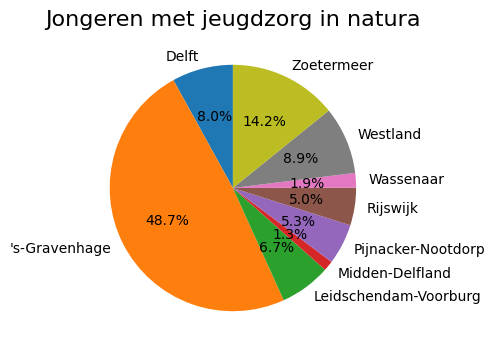

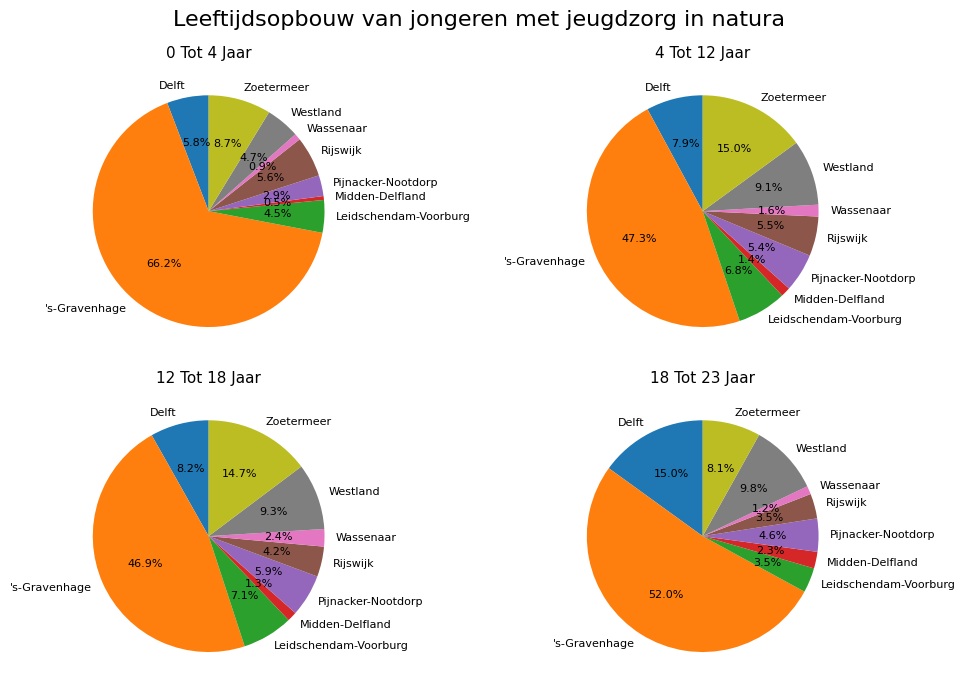

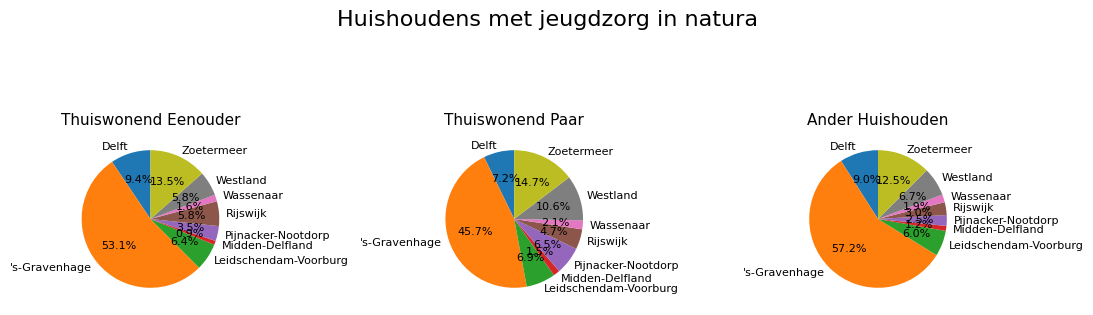

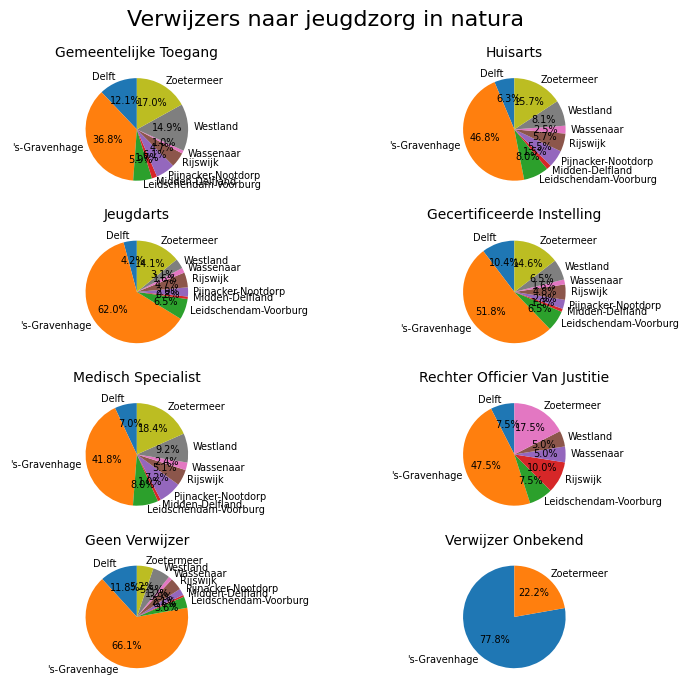

In [ ]:
# VISUALIZATIONS
create_pie_chart(leeftijd, leeftijd.columns[1], 'Wijken', 'Jongeren met jeugdzorg in natura', normalize=True)
create_pie_chart(leeftijd, leeftijd.columns[2:], 'Wijken', 'Leeftijdsopbouw van jongeren met jeugdzorg in natura')
create_pie_chart(huishouden, huishouden.columns[2:], 'Wijken', 'Huishoudens met jeugdzorg in natura')
create_pie_chart(verwijzers, verwijzers.columns[2:], 'Wijken', 'Verwijzers naar jeugdzorg in natura')
